# Lambda School Data Science - Survival Analysis
![My normal approach is useless here, too.](https://imgs.xkcd.com/comics/probability.png)

https://xkcd.com/881/

The aim of survival analysis is to analyze the effect of different risk factors and use them to predict the duration of time between one event ("birth") and another ("death").

# Assignment - Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

Your assignment is to [use their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answer the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

Good luck!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
# Loading the data to get you started
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn_data.info()  # A lot of these are "object" - some may need to be fixed...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## Data Cleaning

In [19]:
# Some columns we just don't need.
churn2 = churn_data.drop(columns = 'customerID')

# The two numerical columns at the end should really be numerical
churn3 = churn2
churn3['MonthlyCharges'] = pd.to_numeric(churn3['MonthlyCharges'])
churn3['TotalCharges'] = pd.to_numeric(churn3['TotalCharges'], 
                                       errors='coerce')

# There are 11 nulls in TotalCharges, which I'll replace with the mean
# value for that column
TotalCharges_mean = churn3['TotalCharges'].mean()
churn3['TotalCharges'].fillna(TotalCharges_mean, inplace=True)

# Lifelines requires numerical yes and no values.
churn4 = churn3.replace({'Yes':1, 'No':0}, inplace=True)

## Snapshot of customer retention

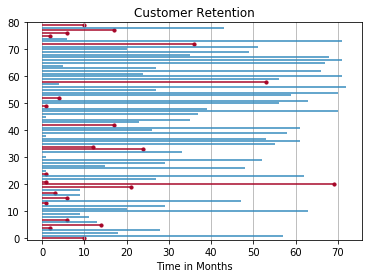

In [5]:
# I'll first plot the lifelines of a sample of 80 customers
churn_sample = churn_data.sample(80)
time = churn_sample.tenure.values
event = churn_sample.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
# ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Customer Retention");
plt.plot();

This is a small sample of the customer population, showing how long customers (individual lines) have been with the company (length of lines). Red lines end when a customer is lost. Blue lines show a customer that is still with the company.

## Survival estimate curve

In [6]:
churn_data.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,0.265370
std,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,0.000000
50%,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,0.000000
75%,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,1.000000
max,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,1.000000


0    0.5
dtype: float64
Median time before losing customer: inf weeks


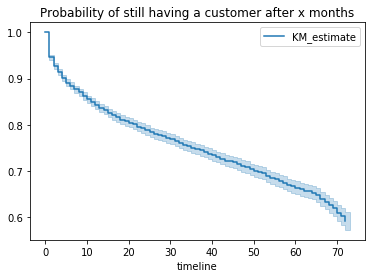

In [7]:
time = churn_data.tenure.values;
event = churn_data.Churn.values;

kmf = lifelines.KaplanMeierFitter();
kmf.fit(time, event_observed=event);
kmf.plot();
plt.title('Probability of still having a customer after x months');
print(f'Median time before losing customer: {kmf.median_} weeks')

### Survival Regression
Which of the factors are important?

In [8]:
# Using Cox Proportional Hazards model
cph = lifelines.CoxPHFitter()
cph.fit(churn_data, 'tenure', event_col='Churn')
cph.print_summary()

TypeError: DataFrame contains nonnumeric columns: ['customerID', 'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'TotalCharges']. Try 1) using pandas.get_dummies to convert the non-numeric column(s) to numerical data, 2) using it in stratification `strata=`, or 3) dropping the column(s).

### What features best model customer churn?
### What would you characterize as the "warning signs" that a customer may discontinue service?
### What actions would you recommend to this business to try to improve their customer retention?

# Resources and stretch goals

Resources:
- [Wikipedia on Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)
- [Wikipedia on Survival functions](https://en.wikipedia.org/wiki/Survival_function)
- [Summary of survival analysis by a biostatistician](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html)
- [Another medical statistics article on survival analysis](https://www.sciencedirect.com/science/article/pii/S1756231716300639)
- [Survival analysis using R lecture slides](http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf)

Stretch goals:
- Make ~5 slides that summarize and deliver your findings, as if you were to present them in a business meeting
- Revisit any of the data from the lecture material, and explore/dig deeper
- Write your own Python functions to calculate a simple hazard or survival function, and try to generate and plot data with them